## Imports

In [ ]:
import cv2
from matplotlib import pyplot as plt
from lane_detection import Line
from sklearn.cluster import DBSCAN
import lane_detection
import lane_following
import numpy as np

## Helper Functions

In [ ]:
def show(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

## Read Image

In [ ]:
frame = cv2.imread("frames/frame1320.jpg")
# frame = cv2.imread("frames/frame660.jpg")
show(frame)

## Slice Image

In [ ]:
# sliced_frame = frame[ int(frame.shape[0] / 2) : frame.shape[0]]
sliced_frame = frame[int(frame.shape[0] / 2) : frame.shape[0]]
show(sliced_frame)

## Convert to Grayscale

In [ ]:
gray = cv2.cvtColor(sliced_frame, cv2.COLOR_BGR2GRAY)  # convert to grayscale
show(gray)


## Blurring

In [ ]:
blur = cv2.GaussianBlur(gray, (19, 19), 0)
show(blur)

## Black and White Conversion

In [ ]:
_, bw_image = cv2.threshold(gray, 90, 255, cv2.THRESH_BINARY)
show(bw_image)

## Edge Detection

In [ ]:
edges = cv2.Canny(
    bw_image, 20, 100, apertureSize=3
)  # detect edges
show(edges)


## Hough Lines to get Lines
Edge detection just highlights the edges, HoughLinesP gives us the points describing important edges

In [ ]:
lines = cv2.HoughLinesP(
    edges,
    rho=1,
    theta=np.pi / 180,
    threshold=100,
    minLineLength=100,
    maxLineGap=20,
)  # detect lines

lines = [Line(line[0][0], line[0][1], line[0][2], line[0][3]) for line in lines]
# lines = lane_detection.merge_colinear_lines(lines)
print(f"{len(lines) = }")
drawn = lane_detection.draw_lines(sliced_frame, lines)

show(drawn)


## Group Lines by Slope
Using DBSCAN, group the lines

In [ ]:
from lane_detection import draw_lines
slopes = [line.slope for line in lines]
slopes = np.array(slopes).reshape(-1, 1)  # convert slopes to a 2d array

slope_tolerance = 0.1
dbscan = DBSCAN(eps=slope_tolerance, min_samples=2)
labels = dbscan.fit_predict(slopes)  # labels is a list of clusters, basically

def group_data(labels: list[int], data: list[any]) -> dict[int, any]:
    """
    Group lines based on labels, which are expected to be the output of a DBSCAN fit.
    """
    grouped_data = {}
    for index, element in enumerate(data):
        label = labels[index]
        if label not in grouped_data:
            grouped_data[label] = []
        grouped_data[label].append(element)
        
    return grouped_data

grouped_lines = group_data(labels, lines)


for group in grouped_lines:
    show(draw_lines(sliced_frame, grouped_lines[group], random=True))
        

## Group and Combine Lines by X-Intercept
Now we have a dictionary pairing all of the lines with similar slopes together. However, this doesn't work great for all cases. Sometimes you have lines with similar slopes, but that are not actually colinear; that is, they are parallel but not intersecting. 
Because of such a case, we must first determine whether the lines share similar x-intercepts before we can merge them.

In [ ]:
x_intercept_tolerance = 50
dbscan = DBSCAN(eps=x_intercept_tolerance, min_samples=1)

for label, lines in grouped_lines.items():
    x_intercepts = [line.x_intercept for line in lines]
    x_intercepts = np.array(x_intercepts).reshape(-1, 1)
    labels = dbscan.fit_predict(x_intercepts)
    grouped_lines[label] = group_data(labels, lines)    

### Test the X-intercept pairings

In [ ]:
for _, slope_group in grouped_lines.items():
    for _, x_group in slope_group.items():
        print(f"{[line.x_intercept for line in x_group]}")
        show(draw_lines(sliced_frame, x_group, random=True))

### Merge the Lines
Now that we finally have all of our lines split into appropriate groupings based on x-intercepts and slopes, we can merge each group.
This is done by collecting all of the x and y points of each group, and then taking the line of best fit in that group. This returns the slope and 
y-intercept of the line, $m$ and $b$.
The points of the new line are found using this form:
$(x_1, y_1), (x_2, y_2) = (0, b), (\text{width}, m * \text{width} + b)$

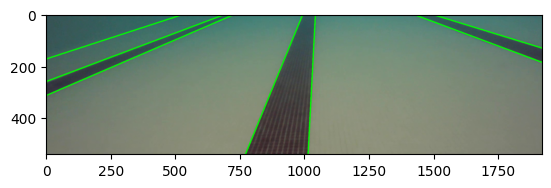

In [20]:
merged_lines = []
for _, slope_group in grouped_lines.items():
    for _, x_group in slope_group.items():
        # for each group, reset the x and y list
        x = []
        y = []
        # create a list of all the x and y coordinates in the group
        for line in x_group:
            x.extend([line.x1, line.x2])
            y.extend([line.y1, line.y2])
        m, b = np.polyfit(x, y, 1) # line of best fit for the points

        x = [0, sliced_frame.shape[1]] # (0, width)
        y = [b, m * x[1] + b] # (b, m * width + b)
        merged_line = Line(x[0], y[0], x[1], y[1])
        merged_lines.append(merged_line)

merged_lines.sort(key=lambda x: x.x_intercept) # sort by x_intercept

show(draw_lines(sliced_frame, merged_lines))



In [21]:
for i, line in enumerate(merged_lines):
    print(f"Line {i}: {line.x_intercept = }, {line.slope = }")

Line 0: line.x_intercept = -1131.0, line.slope = -0.32447916666666665
Line 1: line.x_intercept = -748.0, line.slope = -0.37447916666666664
Line 2: line.x_intercept = -526.0, line.slope = -0.4296875
Line 3: line.x_intercept = 772.0, line.slope = -2.433333333333333
Line 4: line.x_intercept = 1014.0, line.slope = -18.9578125
Line 5: line.x_intercept = 2872.0, line.slope = 0.371875
Line 6: line.x_intercept = 3256.0, line.slope = 0.30625


## Lane Detection
This is perhaps the hardest part of the entire problem. You have a set of lines, hopefully a very accurate and brief one, and you need to pair them together. This is, however, very difficult. There are many, many cases. 
- If the lines are off to the side, their slopes will be parallel and x-intercepts similar; that should be easy. 
- When two lines are near the center, there is many more cases. Their slopes could be opposing, in which case they are pretty much lined up and can be easily paired. However, one of the lines could be nearly vertical, and therefore have a massive slope that is difficult to compare against.

The result is that all of the algorithms I have tried thus far have been very inaccurate; they are the product of overfitting. 
Tomorrow, I intend on trying to solve the lane detection problem in a different way: pixel detection. Not sure how exactly that is going to work yet, but here is the general idea:
1. Pick a pair of 2 lines with similar x-intercepts ($\pm$ 200?) and ensure that neither line has yet been paired
2. Find the average color of the 5-10 pixels between them
3. If:
    1. the color is black (or > than some threshold), then they are a lane; append and break
    2. the color is white (< than some threshold), then they aren't a lane; go back to step 1

In [ ]:
import math
def detect_lanes(lines: list[Line], height: int = 1080, width: int = 1920, center_lane_tol = 0.5, parallel_tol = 0.5, x_intercept_tol = 250) -> list[tuple[Line, Line]]:
    center = width / 2
    lanes = []
    lines.sort(key=lambda x: x.x_intercept)

    for i in range(len(lines[:-1])):
        line1 = lines[i]
        for j in range(i+1, len(lines[:-1])):
            line2 = lines[j]
            # Ensure lines are unpaired
            if line1.is_paired() or line2.is_paired():
                print("lines are paired")
                break
            
            # Check for opposing slopes (lane near center)
            if math.isclose(line1.slope, -1 * line2.slope, abs_tol=center_lane_tol):
                # lines are a lane near the center
                line1.paired = True
                line2.paired = True
                lanes.append((line1, line2))
                print("Pair found with opposing slopes")
                break # line 1 has a match with line 2, so pick a new line 1
            
            # Check for parallel slopes
            elif math.isclose(line1.slope, line2.slope, abs_tol=parallel_tol):
                # slopes are close to parallel
                print("Pair found with parallel slopes, checking for x_intercepts...")
                if math.isclose(
                    line1.x_intercept, line2.x_intercept, rel_tol=x_intercept_tol
                ):
                    # x-intercepts are close
                    if ((line1.x_intercept > center) and (line2.x_intercept > center)) or (
                        (line1.x_intercept < center) and (line2.x_intercept < center)
                    ):
                        # the lines are probably a pair
                        line1.paired = True
                        line2.paired = True
                        lanes.append((line1, line2))
                        print("Similar x-intercepts on the same side of the image, pair added")
                        break # found a pair, so start a new
    return lanes

In [ ]:
lanes = detect_lanes(merged_lines, sliced_frame.shape[0], sliced_frame.shape[1], 0.1, 0.3, 50)
laned_img = lane_detection.draw_lanes(sliced_frame, lanes)
plt.imshow(cv2.cvtColor(laned_img, cv2.COLOR_BGR2RGB))

(center_slope, center_intercept) = lane_following.get_lane_center(lanes)

direction = lane_following.recommend_direction(center_intercept, center_slope, sliced_frame.shape[1])

print(f"The AUV should go to the {direction}")

In [ ]:

# cap = cv2.VideoCapture('AUV_Vid.mkv')

# count = 0 # the number of frames since the last
# frequency = 60 # the number of frames to skip

# while cap.isOpened():
#     ret, frame = cap.read()
#     if count % frequency == 0:
#         cv2.imwrite(f"./frames/frame{count}.jpg", frame)
#         # plt.imshow(cv2.cvtColor(render_frame(frame), cv2.COLOR_BGR2RGB))
#         # plt.show()
        
#     count += 1